# 請結合前面的知識與程式碼，比較不同的 optimizer 與 learning rate 組合對訓練的結果與影響
### 常見的 optimizer 包含
* SGD
* RMSprop
* AdaGrad
* Adam

In [1]:
import os
import keras

# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128]):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, activation="relu", name="hidden_layer"+str(i+1))(input_layer)
        else:
            x = keras.layers.Dense(units=n_units, activation="relu", name="hidden_layer"+str(i+1))(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [6]:

## 超參數設定
LEARNING_RATE = [1e-2, 1e-3, 1e-4]
EPOCHS = 50
BATCH_SIZE = 256
MOMENTUM = 0.5


In [7]:
# optimizer = keras.optimizers.SGD(lr=lr, nesterov=True, momentum=MOMENTUM)

In [8]:
results = {}
"""
使用迴圈，建立不同 Learning rate 的模型並訓練
"""
for lr in LEARNING_RATE:
    keras.backend.clear_session() # 把舊的 Graph 清掉
    print("Experiment with LR = %.6f" % (lr))
    model = build_mlp(input_shape=x_train.shape[1:])
    model.summary()
   
    optimizer = keras.optimizers.SGD(lr=lr, nesterov=True, momentum=MOMENTUM)
    
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True)
    
    # Collect results
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["acc"]
    valid_acc = model.history.history["val_acc"]
    
    exp_name_tag = "exp-lr-%s" % str(lr)
    results[exp_name_tag] = {'train-loss': train_loss,
                             'valid-loss': valid_loss,
                             'train-acc': train_acc,
                             'valid-acc': valid_acc}

Experiment with LR = 0.010000
Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
output (Dense)               (None, 10)                1290      
Total params: 1,738,890
Trainable params: 1,738,890
Non-trainable params: 0
_________________________________________________________________
Instructions for updating:
Use

50000/50000 [==============================] - 2s 47us/step - loss: 1.0594 - acc: 0.6296 - val_loss: 1.4129 - val_acc: 0.5125
Epoch 49/50
50000/50000 [==============================] - 2s 46us/step - loss: 1.0511 - acc: 0.6318 - val_loss: 1.6586 - val_acc: 0.4445
Epoch 50/50
50000/50000 [==============================] - 2s 46us/step - loss: 1.0422 - acc: 0.6379 - val_loss: 1.3721 - val_acc: 0.5169
Experiment with LR = 0.001000
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)

Epoch 50/50
50000/50000 [==============================] - 2s 46us/step - loss: 1.5419 - acc: 0.4636 - val_loss: 1.5699 - val_acc: 0.4539
Experiment with LR = 0.000100
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
output (Dense)               (None, 10)                1290      
Total params: 1,738,890
Trainable params: 1,738,890
Non-trainable params: 0
______________________________

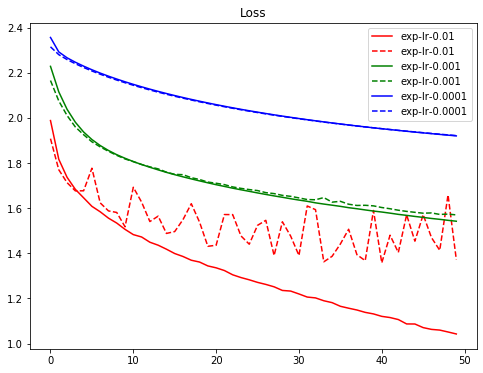

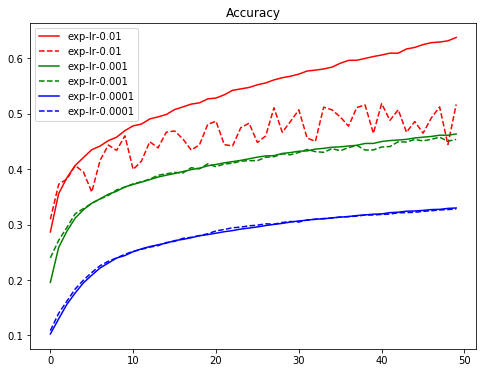

In [9]:

import matplotlib.pyplot as plt
%matplotlib inline
color_bar = ["r", "g", "b", "y", "m", "k"]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend()
plt.show()

In [10]:
#   optimizer = keras.optimizers.Adam(lr=lr)

In [11]:
results = {}
"""
使用迴圈，建立不同 Learning rate 的模型並訓練
"""
for lr in LEARNING_RATE:
    keras.backend.clear_session() # 把舊的 Graph 清掉
    print("Experiment with LR = %.6f" % (lr))
    model = build_mlp(input_shape=x_train.shape[1:])
    model.summary()
   
    #optimizer = keras.optimizers.SGD(lr=lr, nesterov=True, momentum=MOMENTUM)
    optimizer = keras.optimizers.Adam(lr=lr)
    
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True)
    
    # Collect results
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["acc"]
    valid_acc = model.history.history["val_acc"]
    
    exp_name_tag = "exp-lr-%s" % str(lr)
    results[exp_name_tag] = {'train-loss': train_loss,
                             'valid-loss': valid_loss,
                             'train-acc': train_acc,
                             'valid-acc': valid_acc}

Experiment with LR = 0.010000
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
output (Dense)               (None, 10)                1290      
Total params: 1,738,890
Trainable params: 1,738,890
Non-trainable params: 0
_________________________________________________________________
Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [============================

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 3s 62us/step - loss: 1.9482 - acc: 0.2949 - val_loss: 1.7704 - val_acc: 0.3642
Epoch 2/50
50000/50000 [==============================] - 3s 57us/step - loss: 1.7179 - acc: 0.3867 - val_loss: 1.6940 - val_acc: 0.3895
Epoch 3/50
50000/50000 [==============================] - 3s 56us/step - loss: 1.6290 - acc: 0.4189 - val_loss: 1.6002 - val_acc: 0.4315
Epoch 4/50
50000/50000 [==============================] - 3s 57us/step - loss: 1.5618 - acc: 0.4434 - val_loss: 1.5290 - val_acc: 0.4539
Epoch 5/50
50000/50000 [==============================] - 3s 57us/step - loss: 1.5108 - acc: 0.4609 - val_loss: 1.5188 - val_acc: 0.4594
Epoch 6/50
50000/50000 [==============================] - 3s 57us/step - loss: 1.4713 - acc: 0.4764 - val_loss: 1.4925 - val_acc: 0.4675
Epoch 7/50
50000/50000 [==============================] - 3s 56us/step - loss: 1.4410 - acc: 0.4857 - val_loss: 1.4976 - val_acc

50000/50000 [==============================] - 3s 55us/step - loss: 1.7180 - acc: 0.3948 - val_loss: 1.6620 - val_acc: 0.4136
Epoch 3/50
50000/50000 [==============================] - 3s 55us/step - loss: 1.6355 - acc: 0.4242 - val_loss: 1.6218 - val_acc: 0.4257
Epoch 4/50
50000/50000 [==============================] - 3s 55us/step - loss: 1.5801 - acc: 0.4433 - val_loss: 1.5575 - val_acc: 0.4477
Epoch 5/50
50000/50000 [==============================] - 3s 55us/step - loss: 1.5393 - acc: 0.4562 - val_loss: 1.5299 - val_acc: 0.4565
Epoch 6/50
50000/50000 [==============================] - 3s 55us/step - loss: 1.4999 - acc: 0.4720 - val_loss: 1.4962 - val_acc: 0.4685
Epoch 7/50
50000/50000 [==============================] - 3s 55us/step - loss: 1.4639 - acc: 0.4852 - val_loss: 1.4886 - val_acc: 0.4734
Epoch 8/50
50000/50000 [==============================] - 3s 55us/step - loss: 1.4342 - acc: 0.4939 - val_loss: 1.4662 - val_acc: 0.4844
Epoch 9/50
50000/50000 [============================

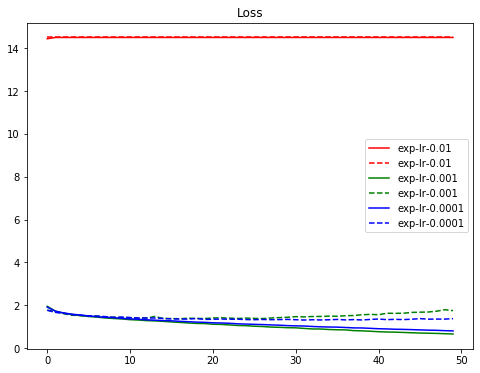

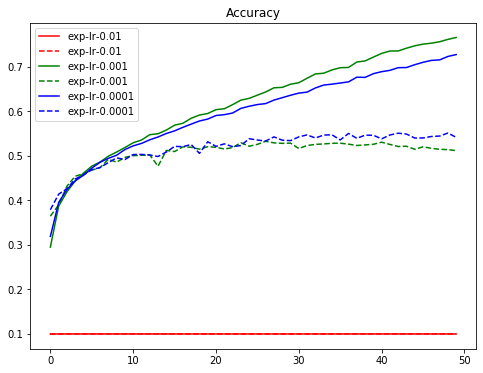

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline
color_bar = ["r", "g", "b", "y", "m", "k"]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend()
plt.show()

In [13]:
# optimizer = keras.optimizers.RMSprop(lr=lr, rho=0.9, epsilon=None, decay=0.0)

In [14]:
results = {}
"""
使用迴圈，建立不同 Learning rate 的模型並訓練
"""
for lr in LEARNING_RATE:
    keras.backend.clear_session() # 把舊的 Graph 清掉
    print("Experiment with LR = %.6f" % (lr))
    model = build_mlp(input_shape=x_train.shape[1:])
    model.summary()
   
    #optimizer = keras.optimizers.SGD(lr=lr, nesterov=True, momentum=MOMENTUM)
    optimizer = keras.optimizers.RMSprop(lr=lr, rho=0.9, epsilon=None, decay=0.0) 
    
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True)
    
    # Collect results
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["acc"]
    valid_acc = model.history.history["val_acc"]
    
    exp_name_tag = "exp-lr-%s" % str(lr)
    results[exp_name_tag] = {'train-loss': train_loss,
                             'valid-loss': valid_loss,
                             'train-acc': train_acc,
                             'valid-acc': valid_acc}

Experiment with LR = 0.010000
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
output (Dense)               (None, 10)                1290      
Total params: 1,738,890
Trainable params: 1,738,890
Non-trainable params: 0
_________________________________________________________________
Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [============================

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 3s 55us/step - loss: 2.2296 - acc: 0.2205 - val_loss: 1.9533 - val_acc: 0.2955
Epoch 2/50
50000/50000 [==============================] - 3s 51us/step - loss: 1.8794 - acc: 0.3209 - val_loss: 1.9007 - val_acc: 0.3082
Epoch 3/50
50000/50000 [==============================] - 3s 51us/step - loss: 1.7790 - acc: 0.3624 - val_loss: 1.8225 - val_acc: 0.3425
Epoch 4/50
50000/50000 [==============================] - 3s 51us/step - loss: 1.7042 - acc: 0.3885 - val_loss: 1.7205 - val_acc: 0.3746
Epoch 5/50
50000/50000 [==============================] - 3s 51us/step - loss: 1.6515 - acc: 0.4102 - val_loss: 1.8046 - val_acc: 0.3561
Epoch 6/50
50000/50000 [==============================] - 3s 51us/step - loss: 1.5999 - acc: 0.4281 - val_loss: 1.7048 - val_acc: 0.3769
Epoch 7/50
50000/50000 [==============================] - 3s 51us/step - loss: 1.5612 - acc: 0.4420 - val_loss: 1.6650 - val_acc

50000/50000 [==============================] - 3s 51us/step - loss: 1.7945 - acc: 0.3621 - val_loss: 1.7701 - val_acc: 0.3593
Epoch 3/50
50000/50000 [==============================] - 3s 52us/step - loss: 1.7150 - acc: 0.3921 - val_loss: 1.7908 - val_acc: 0.3687
Epoch 4/50
50000/50000 [==============================] - 3s 52us/step - loss: 1.6625 - acc: 0.4094 - val_loss: 1.7373 - val_acc: 0.3673
Epoch 5/50
50000/50000 [==============================] - 3s 52us/step - loss: 1.6215 - acc: 0.4257 - val_loss: 1.6353 - val_acc: 0.4232
Epoch 6/50
50000/50000 [==============================] - 3s 53us/step - loss: 1.5865 - acc: 0.4388 - val_loss: 1.7211 - val_acc: 0.3892
Epoch 7/50
50000/50000 [==============================] - 3s 54us/step - loss: 1.5543 - acc: 0.4510 - val_loss: 1.5648 - val_acc: 0.4449
Epoch 8/50
50000/50000 [==============================] - 3s 52us/step - loss: 1.5259 - acc: 0.4609 - val_loss: 1.5917 - val_acc: 0.4367
Epoch 9/50
50000/50000 [============================

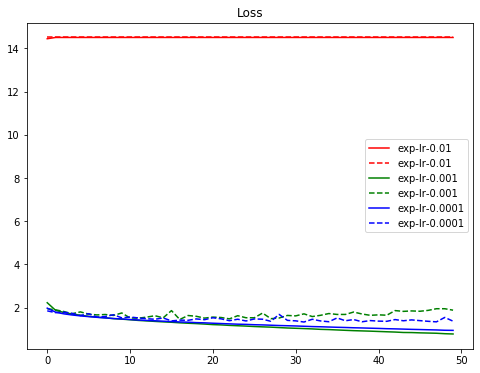

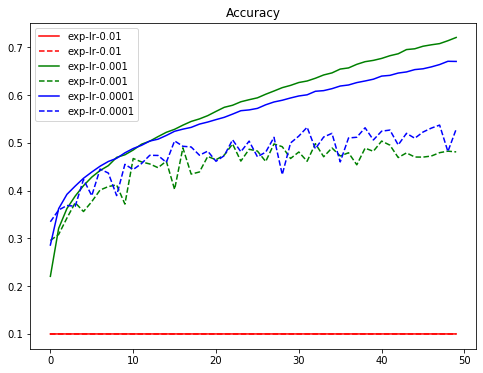

In [15]:
import matplotlib.pyplot as plt
%matplotlib inline
color_bar = ["r", "g", "b", "y", "m", "k"]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend()
plt.show()

In [16]:
#optimizer = keras.optimizers.Adagrad(lr=lr, epsilon=None, decay=0.0)

In [17]:
results = {}
"""
使用迴圈，建立不同 Learning rate 的模型並訓練
"""
for lr in LEARNING_RATE:
    keras.backend.clear_session() # 把舊的 Graph 清掉
    print("Experiment with LR = %.6f" % (lr))
    model = build_mlp(input_shape=x_train.shape[1:])
    model.summary()
   
    #optimizer = keras.optimizers.SGD(lr=lr, nesterov=True, momentum=MOMENTUM)
    optimizer = keras.optimizers.Adagrad(lr=lr, epsilon=None, decay=0.0)
    
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True)
    
    # Collect results
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["acc"]
    valid_acc = model.history.history["val_acc"]
    
    exp_name_tag = "exp-lr-%s" % str(lr)
    results[exp_name_tag] = {'train-loss': train_loss,
                             'valid-loss': valid_loss,
                             'train-acc': train_acc,
                             'valid-acc': valid_acc}

Experiment with LR = 0.010000
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
output (Dense)               (None, 10)                1290      
Total params: 1,738,890
Trainable params: 1,738,890
Non-trainable params: 0
_________________________________________________________________
Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [============================

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 3s 54us/step - loss: 2.0124 - acc: 0.2788 - val_loss: 1.9004 - val_acc: 0.3117
Epoch 2/50
50000/50000 [==============================] - 3s 51us/step - loss: 1.8173 - acc: 0.3595 - val_loss: 1.8188 - val_acc: 0.3392
Epoch 3/50
50000/50000 [==============================] - 3s 50us/step - loss: 1.7469 - acc: 0.3871 - val_loss: 1.7469 - val_acc: 0.3745
Epoch 4/50
50000/50000 [==============================] - 3s 51us/step - loss: 1.6996 - acc: 0.4061 - val_loss: 1.7072 - val_acc: 0.3974
Epoch 5/50
50000/50000 [==============================] - 3s 52us/step - loss: 1.6596 - acc: 0.4185 - val_loss: 1.6752 - val_acc: 0.4065
Epoch 6/50
50000/50000 [==============================] - 2s 49us/step - loss: 1.6298 - acc: 0.4305 - val_loss: 1.7044 - val_acc: 0.3762
Epoch 7/50
50000/50000 [==============================] - 2s 50us/step - loss: 1.6035 - acc: 0.4413 - val_loss: 1.6025 - val_acc

Epoch 2/50
50000/50000 [==============================] - 3s 51us/step - loss: 1.9291 - acc: 0.3314 - val_loss: 1.9050 - val_acc: 0.3405
Epoch 3/50
50000/50000 [==============================] - 3s 51us/step - loss: 1.8856 - acc: 0.3469 - val_loss: 1.8709 - val_acc: 0.3514
Epoch 4/50
50000/50000 [==============================] - 3s 51us/step - loss: 1.8575 - acc: 0.3545 - val_loss: 1.8495 - val_acc: 0.3527
Epoch 5/50
50000/50000 [==============================] - 3s 51us/step - loss: 1.8371 - acc: 0.3610 - val_loss: 1.8339 - val_acc: 0.3645
Epoch 6/50
50000/50000 [==============================] - 3s 51us/step - loss: 1.8217 - acc: 0.3658 - val_loss: 1.8214 - val_acc: 0.3600
Epoch 7/50
50000/50000 [==============================] - 3s 51us/step - loss: 1.8085 - acc: 0.3706 - val_loss: 1.8049 - val_acc: 0.3707
Epoch 8/50
50000/50000 [==============================] - 3s 51us/step - loss: 1.7969 - acc: 0.3747 - val_loss: 1.7962 - val_acc: 0.3740
Epoch 9/50
50000/50000 [=================

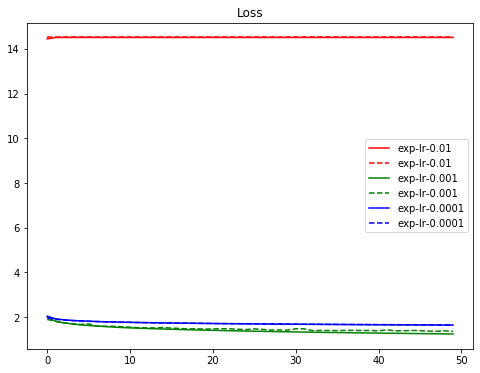

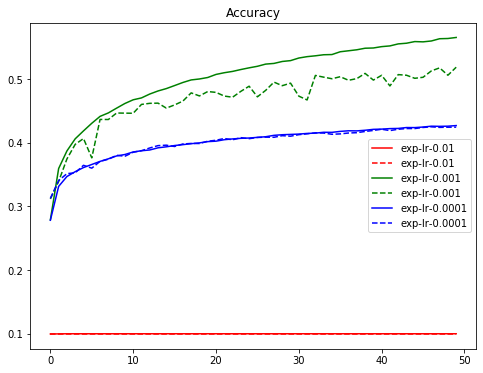

In [18]:
import matplotlib.pyplot as plt
%matplotlib inline
color_bar = ["r", "g", "b", "y", "m", "k"]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend()
plt.show()